# Imports and initial settings

In [13]:
pip install mysql-connector-python

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\kmedriano\Documents\Cactus\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [14]:
import mysql.connector
import matplotlib.pyplot as plt
import requests
import json
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from matplotlib import colors
# plt.rcParams['figure.figsize'] = [12, 5]
# plt.rcParams['figure.figsize'] = [15, 6]
plt.rcParams['figure.figsize'] = [9, 6]

# n_trials    = 180
n_trials    = 150
n_trials_tt = int(n_trials/3)

# n_split     = 3
n_split     = 6
# n_split     = 10

plot_indiv = False

In [15]:
API_URL = "http://134.76.24.67/node" 

# Get Data

### Trial data

In [16]:
# get trial info
# r = requests.get(API_URL+"/trial")
# print("Status:",r.status_code)
# pd_data = []
# trials = json.loads(r.text)
# for t in trials:
#     record = [t["trial_id"], t["session_id"],t["silhouette_id"], t["time_stamp"], t["reward"], t["timeout"]]
#     pd_data.append(record)
# # print(t)
# print("Found", len(pd_data), "trials")    
# trial_df = pd.DataFrame(pd_data, columns=['trial_id','session_id','silhouette_id', 'time_stamp', 'reward', 'timeout'])
# trial_df.tail()

r = requests.get(API_URL+"/trial")
print("Status:",r.status_code)
pd_data = []
trials = json.loads(r.text)
for t in trials:
    #print(t)
    record = [t["trial_id"], t["session_id"],t["silhouette_id"], t["time_stamp"], t["reward"], t["timeout"], t["experiment_part"],t["trial_type"]]
    pd_data.append(record)
print("Found", len(pd_data), "trials")    
trial_df = pd.DataFrame(pd_data, columns=['trial_id','session_id','silhouette_id', 'time_stamp', 'reward', 'timeout','experiment_part', 'trial_type'])
#trial_df.tail()
#trial_df.head()

Status: 200
Found 32264 trials


In [36]:
trial_df.head()

,trial_id,session_id,silhouette_id,time_stamp,reward,timeout,experiment_part,trial_type
0,1,1,149,1636029597122,0,0.0,NaN,NaN
1,2,1,39,1636029607072,0,NaN,NaN,NaN
2,3,2,104,1636029691260,0,0.0,NaN,NaN
3,4,2,203,1636029700067,0,0.0,NaN,NaN
4,5,2,159,1636029706274,1,0.0,NaN,NaN


### Silhouette data

In [17]:
# get silhouette info
r = requests.get(API_URL+"/silhouette")
print("Status:", r.status_code)
pd_data = []
silhouettes = json.loads(r.text)
for s in silhouettes:
    record = [s["silhouette_id"], s["solution"], s["trial_type"]]
    pd_data.append(record)

# print(s)
print("Found", len(pd_data), "silhouettes")
    
silhouette_df = pd.DataFrame(pd_data, columns=["silhouette_id","solution","trial_type"])
silhouette_df.head()
print(silhouette_df.shape)

Status: 200
Found 2220 silhouettes
(2220, 3)


In [215]:
silhouette_df.head()

,silhouette_id,solution,trial_type
0,0,"[{""x"":3, ""y"":4, ""id"":0},{""x"":5, ""y"":2, ""id"":1}...",0
1,1,"[{""x"":3, ""y"":4, ""id"":0},{""x"":5, ""y"":3, ""id"":1}...",2
2,2,"[{""x"":2, ""y"":3, ""id"":1},{""x"":5, ""y"":4, ""id"":3}...",1
3,3,"[{""x"":3, ""y"":2, ""id"":1},{""x"":4, ""y"":5, ""id"":3}...",1
4,4,"[{""x"":5, ""y"":4, ""id"":2},{""x"":3, ""y"":7, ""id"":3}...",2


### Session data

In [18]:
# get session info
r = requests.get(API_URL+"/session")
print("Status:",r.status_code)
pd_data = []
sessions = json.loads(r.text)
for s in sessions:
    # print(s)
    record = [s["session_id"], s["participant_id"], s["comment"]]
    pd_data.append(record)
    # print(s["comment"])

# print(s)
print("Found", len(pd_data), "sessions")    

session_df = pd.DataFrame(pd_data, columns=['session_id', 'participant_id', 'comment'])
#session_df.tail()

Status: 200
Found 1223 sessions


### Actions data

In [19]:
# get actions
r = requests.get(API_URL+"/action")
print("Status:", r.status_code)
pd_data = []
actions = json.loads(r.text)
for a in actions:
    if a["building_block"] in [str(i) for i in range(9)]:
        record = [a["action_id"], a["trial"], int(a["building_block"]), a["reaction_time"], a["selected"]==1]
        pd_data.append(record)
print("Found", len(pd_data), "actions")
    
action_df = pd.DataFrame(pd_data, columns=['action_id', 'trial_id', 'building_block', 'reaction_time', 'selected'])
#action_df.head()
#action_df[:10]

Status: 200
Found 96836 actions


# Pre-processing

### Filtering the trial data to my session (session_id=1171)

In [20]:
import re

In [21]:
trial_mine_copy = trial_df.query('session_id == 1171').copy()
trial_mine_copy.iloc[:,-1].unique() #150 silhouettes

array([2.])

In [22]:
# Modifying/cleaning the trial dataframe: adding a new column with numbered silhouette id 
# I need something that would parse something of this type: RelGraphsStimSet0_0 
# assumption: I would only need the number after _

# filter: _%   where % is a placeholder for any number
# extract the number

cleaned_sil_id_array = []

for i in np.arange(len(trial_mine_copy)):
    text = trial_mine_copy.iloc[i, 2] # the entry in the silhouette_id column, this is a string
    sil_id_str = re.split("_", text) # split the string at _, now I have a list of len 2
    sil_id =  int(sil_id_str[1]) # extracting relevant info; correspond to actual silhouette id, convert to int
    cleaned_sil_id_array.append(sil_id) # the append is ordered
    
# Now I have a list, I can just add this to a new column in the dataframe

trial_mine_copy["silhouette_id"] = cleaned_sil_id_array # changing the silhouette id column

trial_mine_copy

,trial_id,session_id,silhouette_id,time_stamp,reward,timeout,experiment_part,trial_type
28880,28881,1171,0,1658904481617,1,0.0,0.0,2.0
28881,28882,1171,1,1658904490028,1,0.0,0.0,2.0
28882,28883,1171,2,1658904496808,0,0.0,0.0,2.0
28883,28884,1171,3,1658904503718,1,0.0,0.0,2.0
28884,28885,1171,4,1658904510702,1,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...
29025,29026,1171,145,1658906121678,1,0.0,2.0,2.0
29026,29027,1171,146,1658906131054,1,0.0,2.0,2.0
29027,29028,1171,147,1658906138538,1,0.0,2.0,2.0
29028,29029,1171,148,1658906147392,1,0.0,2.0,2.0


#### Cleaning trial_df for ids [1171, 1195,1197,1199,1203,1204]

In [46]:
# for ids:[1171, 1195,1197,1199,1203,1204]

ids = [1171, 1195,1197,1199,1203,1204]

trial_copy_selected_ids = trial_df.query(f'session_id in {ids}').copy()
#trial_copy_selected_ids.iloc[:,-1].unique() #150 silhouettes

cleaned_sil_id_array = []

for i in np.arange(len(trial_copy_selected_ids)):
    text = trial_copy_selected_ids.iloc[i, 2] # the entry in the silhouette_id column, this is a string
    sil_id_str = re.split("_", text) # split the string at _, now I have a list of len 2
    sil_id =  int(sil_id_str[1]) # extracting relevant info; correspond to actual silhouette id, convert to int
    cleaned_sil_id_array.append(sil_id) # the append is ordered
    
# Now I have a list, I can just add this to a new column in the dataframe

trial_copy_selected_ids["silhouette_id"] = cleaned_sil_id_array # changing the silhouette id column

print(trial_copy_selected_ids.iloc[:,1].unique())
trial_copy_selected_ids[:151]

[1171 1195 1197 1199 1203 1204]


,trial_id,session_id,silhouette_id,time_stamp,reward,timeout,experiment_part,trial_type
28880,28881,1171,0,1658904481617,1,0.0,0.0,2.0
28881,28882,1171,1,1658904490028,1,0.0,0.0,2.0
28882,28883,1171,2,1658904496808,0,0.0,0.0,2.0
28883,28884,1171,3,1658904503718,1,0.0,0.0,2.0
28884,28885,1171,4,1658904510702,1,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...
29026,29027,1171,146,1658906131054,1,0.0,2.0,2.0
29027,29028,1171,147,1658906138538,1,0.0,2.0,2.0
29028,29029,1171,148,1658906147392,1,0.0,2.0,2.0
29029,29030,1171,149,1658906154827,1,0.0,2.0,2.0


### Silhouette data, added a column which specifies the building blocks in a list

In [57]:
# loading the silhouette solutions (in an ordered way) for the current ground truth adjacency (for ids:[1171, 1195,1197,1199,1203,1204]) 

solution_array_current = pd.read_csv(f"C:\\Users\\kmedriano\\Documents\\Cactus\\data\\Solutions.csv")

solution_array_current['silhouette_id'] = np.arange(150) # so I could merge easily

block_list = []  # list of the blocks, so I could use the current function that I have
for i in np.arange(150):
    b1 = int(solution_array_current.iloc[i,0])
    b2 = int(solution_array_current.iloc[i,1])
    b3 = int(solution_array_current.iloc[i,2])
    b4 = int(solution_array_current.iloc[i,3])
    l = [b1,b2,b3,b4]
    block_list.append(l)

solution_array_current["block_connect_list"] = block_list

solution_array_current

,Block 1,Block 2,Block 3,Block 4,silhouette_id,block_connect_list
0,0,5,2,1,0,"[0, 5, 2, 1]"
1,1,3,2,5,1,"[1, 3, 2, 5]"
2,4,5,2,3,2,"[4, 5, 2, 3]"
3,0,4,5,2,3,"[0, 4, 5, 2]"
4,0,5,2,1,4,"[0, 5, 2, 1]"
...,...,...,...,...,...,...
145,3,1,2,5,145,"[3, 1, 2, 5]"
146,1,3,2,5,146,"[1, 3, 2, 5]"
147,0,5,2,3,147,"[0, 5, 2, 3]"
148,4,0,5,2,148,"[4, 0, 5, 2]"


In [24]:
silhouette_df.query('silhouette_id == 0') # this is why my pd.merge didn't work, i assumed that there's a unique silhouette id per trial type; verify with Philipp
silhouette_ids = silhouette_df.loc[:,'silhouette_id'].unique()

silhouette_df_copy = silhouette_df.copy()

# Cleaning silhouette dataframe: changing the solution column from a string to an ordered list (like solution array)
# I need something that would parse something of this type: [{"x":3, "y":4, "id":0},{"x":5, "y":3, "id":1},{"x":2, "y":5, "id":3},{"x":5, "y":4, "id":5}]

# filter: "id":%}   where % is a placeholder for any number
# extract the number in ordered sequence

solution_array = []

for i in np.arange(len(silhouette_df_copy)):
    solution_str = silhouette_df_copy.iloc[i, 1] # the entry in the solution column
    digits = re.findall('\d',solution_str) # get all digits
    bb_digits = digits[2:12:3] # return only those digits that correspond to actual bb indices, it will actually return a list
    solution_array.append(bb_digits) # the append is ordered
    
# Now I have a list, I can just add this to a new column in the dataframe

silhouette_df_copy["solution_array"] = solution_array

silhouette_df_copy

,silhouette_id,solution,trial_type,solution_array
0,0,"[{""x"":3, ""y"":4, ""id"":0},{""x"":5, ""y"":2, ""id"":1}...",0,"[0, 1, 2, 4]"
1,1,"[{""x"":3, ""y"":4, ""id"":0},{""x"":5, ""y"":3, ""id"":1}...",2,"[0, 1, 3, 5]"
2,2,"[{""x"":2, ""y"":3, ""id"":1},{""x"":5, ""y"":4, ""id"":3}...",1,"[1, 3, 4, 5]"
3,3,"[{""x"":3, ""y"":2, ""id"":1},{""x"":4, ""y"":5, ""id"":3}...",1,"[1, 3, 4, 5]"
4,4,"[{""x"":5, ""y"":4, ""id"":2},{""x"":3, ""y"":7, ""id"":3}...",2,"[2, 3, 4, 5]"
...,...,...,...,...
2215,145,"[{""x"":6, ""y"":4, ""id"":0},{""x"":3, ""y"":5, ""id"":2}...",2,"[0, 2, 4, 5]"
2216,146,"[{""x"":3, ""y"":3, ""id"":1},{""x"":5, ""y"":4, ""id"":2}...",2,"[1, 2, 3, 5]"
2217,147,"[{""x"":6, ""y"":5, ""id"":1},{""x"":6, ""y"":3, ""id"":2}...",2,"[1, 2, 4, 5]"
2218,148,"[{""x"":4, ""y"":4, ""id"":0},{""x"":7, ""y"":2, ""id"":2}...",2,"[0, 2, 4, 5]"


### Joining

In [25]:
# Inner join of trial_mine_copy and silhouette_df_copy

# copy the dataframes
trial_mine_copy_copy = trial_mine_copy.copy()
silhouette_df_copy_copy = silhouette_df_copy.copy()

print(trial_mine_copy_copy.head()) #silhouette_id is int
print(silhouette_df_copy_copy.head()) 

       trial_id  session_id  silhouette_id     time_stamp  reward  timeout  \
28880     28881        1171              0  1658904481617       1      0.0   
28881     28882        1171              1  1658904490028       1      0.0   
28882     28883        1171              2  1658904496808       0      0.0   
28883     28884        1171              3  1658904503718       1      0.0   
28884     28885        1171              4  1658904510702       1      0.0   

       experiment_part  trial_type  
28880              0.0         2.0  
28881              0.0         2.0  
28882              0.0         2.0  
28883              0.0         2.0  
28884              0.0         2.0  
   silhouette_id                                           solution  \
0              0  [{"x":3, "y":4, "id":0},{"x":5, "y":2, "id":1}...   
1              1  [{"x":3, "y":4, "id":0},{"x":5, "y":3, "id":1}...   
2              2  [{"x":2, "y":3, "id":1},{"x":5, "y":4, "id":3}...   
3              3  [{"x":3

In [26]:
action_df.query('selected == "False"') #idk what "selected" is for
silhouette_df_copy_copy.query('silhouette_id == 0') # this is the weird thing, why do i have multiple silhouette ids

,silhouette_id,solution,trial_type,solution_array
0,0,"[{""x"":3, ""y"":4, ""id"":0},{""x"":5, ""y"":2, ""id"":1}...",0,"[0, 1, 2, 4]"
180,0,"[{""x"":4, ""y"":3, ""id"":0},{""x"":4, ""y"":1, ""id"":2}...",2,"[0, 2, 3, 5]"
330,0,"[{""x"":8, ""y"":5, ""id"":2},{""x"":5, ""y"":5, ""id"":3}...",0,"[2, 3, 4, 5]"
480,0,"[{""x"":3, ""y"":4, ""id"":0},{""x"":3, ""y"":6, ""id"":3}...",1,"[0, 3, 4, 5]"
630,0,"[{""x"":1, ""y"":4, ""id"":0},{""x"":3, ""y"":4, ""id"":1}...",1,"[0, 1, 2, 4]"
810,0,"[{""x"":3, ""y"":5, ""id"":0},{""x"":3, ""y"":7, ""id"":3}...",0,"[0, 3, 4, 5]"
960,0,"[{""x"":4, ""y"":2, ""id"":0},{""x"":2, ""y"":5, ""id"":3}...",1,"[0, 3, 4, 5]"
1110,0,"[{""x"":3, ""y"":2, ""id"":0},{""x"":3, ""y"":4, ""id"":1}...",2,"[0, 1, 4, 5]"
1290,0,"[{""x"":6, ""y"":5, ""id"":0},{""x"":3, ""y"":3, ""id"":2}...",1,"[0, 2, 3, 4]"
1470,0,"[{""x"":5, ""y"":5, ""id"":0},{""x"":4, ""y"":6, ""id"":2}...",2,"[0, 2, 4, 5]"


In [27]:
# Join the two

#inner_trial_sil_mine = pd.concat([trial_mine_copy_copy, silhouette_df_copy_copy], axis=1)
inner_trial_sil_mine = pd.merge(trial_mine_copy_copy, silhouette_df_copy_copy, on= ["silhouette_id","trial_type"])
inner_trial_sil_mine.head()

,trial_id,session_id,silhouette_id,time_stamp,reward,timeout,experiment_part,trial_type,solution,solution_array
0,28881,1171,0,1658904481617,1,0.0,0.0,2.0,"[{""x"":4, ""y"":3, ""id"":0},{""x"":4, ""y"":1, ""id"":2}...","[0, 2, 3, 5]"
1,28881,1171,0,1658904481617,1,0.0,0.0,2.0,"[{""x"":3, ""y"":2, ""id"":0},{""x"":3, ""y"":4, ""id"":1}...","[0, 1, 4, 5]"
2,28881,1171,0,1658904481617,1,0.0,0.0,2.0,"[{""x"":5, ""y"":5, ""id"":0},{""x"":4, ""y"":6, ""id"":2}...","[0, 2, 4, 5]"
3,28881,1171,0,1658904481617,1,0.0,0.0,2.0,"[{""x"":6, ""y"":5, ""id"":0},{""x"":4, ""y"":3, ""id"":2}...","[0, 2, 3, 4]"
4,28881,1171,0,1658904481617,1,0.0,0.0,2.0,"[{""x"":5, ""y"":4, ""id"":2},{""x"":5, ""y"":2, ""id"":3}...","[2, 3, 4, 5]"


In [51]:
solution_array_current.head()

,Block 1,Block 2,Block 3,Block 4,silhouette_id
0,0,5,2,1,0
1,1,3,2,5,1
2,4,5,2,3,2
3,0,4,5,2,3
4,0,5,2,1,4


In [52]:
# for ids:[1171, 1195,1197,1199,1203,1204]
trial_copy_selected_ids.head()


,trial_id,session_id,silhouette_id,time_stamp,reward,timeout,experiment_part,trial_type
28880,28881,1171,0,1658904481617,1,0.0,0.0,2.0
28881,28882,1171,1,1658904490028,1,0.0,0.0,2.0
28882,28883,1171,2,1658904496808,0,0.0,0.0,2.0
28883,28884,1171,3,1658904503718,1,0.0,0.0,2.0
28884,28885,1171,4,1658904510702,1,0.0,0.0,2.0


In [58]:
# now I want to join solution_array_current and trial_copy_selected_ids, where index of solution_array_current == silhouette_id of trial_copy_selected_ids

merged_selected_ids = pd.merge(trial_copy_selected_ids,solution_array_current, on='silhouette_id')
merged_selected_ids # now I have this data

,trial_id,session_id,silhouette_id,time_stamp,reward,timeout,experiment_part,trial_type,Block 1,Block 2,Block 3,Block 4,block_connect_list
0,28881,1171,0,1658904481617,1,0.0,0.0,2.0,0,5,2,1,"[0, 5, 2, 1]"
1,30386,1195,0,1661243833672,1,0.0,0.0,2.0,0,5,2,1,"[0, 5, 2, 1]"
2,30423,1197,0,1661244248919,1,0.0,0.0,2.0,0,5,2,1,"[0, 5, 2, 1]"
3,30460,1199,0,1661244472463,0,0.0,0.0,2.0,0,5,2,1,"[0, 5, 2, 1]"
4,30660,1203,0,1661245476938,0,NaN,0.0,2.0,0,5,2,1,"[0, 5, 2, 1]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,30683,1195,149,1661245570875,1,0.0,2.0,2.0,1,2,5,0,"[1, 2, 5, 0]"
896,30789,1197,149,1661246288957,1,0.0,2.0,2.0,1,2,5,0,"[1, 2, 5, 0]"
897,30959,1199,149,1661247411966,1,0.0,2.0,2.0,1,2,5,0,"[1, 2, 5, 0]"
898,30985,1203,149,1661247747023,1,0.0,2.0,2.0,1,2,5,0,"[1, 2, 5, 0]"


# Analysis

### Summed response times for perceptual chunk learning

In [29]:
# extracting relevant data
sliced_action_df = action_df[["trial_id","reaction_time"]]
trial_grouped = sliced_action_df.groupby("trial_id")

# grouped by
d2 = trial_grouped["reaction_time"].sum().to_frame(name="reaction_time").reset_index()

# removing RT > 20
valid_RT = d2.loc[(d2["reaction_time"]<=20) & (d2["reaction_time"]>=0)]

# valid_RT
rt = valid_RT["reaction_time"]

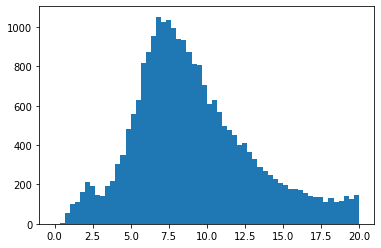

In [30]:
# histogram of summed response times for perceptual chunk learning

rt_array = np.array(rt)
plt.hist(rt_array,bins=60, range=(0,20))
plt.show()

In [31]:
rt_array.shape

(23829,)

# RT scaling and prediction

### RT scaling

Identify parameter for the model "RT = b_0 + b_1*X where b_0 and b_1 are parameters and X is the summed log probabilities" such that RTs would be within the range of valid reaction times

In [32]:
from sklearn.linear_model import LinearRegression
from itertools import *

In [33]:
# Posterior

posterior = np.load(f"C:\\Users\\kmedriano\\Documents\\Cactus\\tests\\learned_adjacency\\posterior_trial.npy")

# X

solution_array = np.load(f"C:\\Users\\kmedriano\\Documents\\Cactus\\tests\\silhouettes\\solutions_20220803-104805.npy")
array_size = solution_array.shape[0]

summed_log_prob = np.zeros(array_size)

for sil in np.arange(array_size):
    # list of pairs of blocks in a silhouette
    tuple_list = list(combinations(solution_array[sil],2)) #2 since we're concerned with chunks composed of 2 blocks, list of tuples
    for (i,j) in tuple_list:
        if posterior[i,j] != 0:
            summed_log_prob[sil] += np.log(posterior[i,j]) # this will most likely be a negative number

summed_log_prob = summed_log_prob.reshape(-1,1)

# RT

# For now I'm just sampling 150 summed RTs in the data that Philipp has

rand_idx = np.random.randint(22117+1, size=array_size) #22117 is length of the array
rand_sample_rt = rt_array[rand_idx]

rand_sample_rt.reshape(-1,1)

print(summed_log_prob.shape)
print(rand_sample_rt.shape)

rand_sample_rt = rand_sample_rt.reshape(-1,1)

# RT scaling using "RT = b_0 + b_1*X where b_0 and b_1 are parameters and X is the summed log probabilities"
# I want a value for b_0 and b_1

reg = LinearRegression().fit(summed_log_prob,rand_sample_rt)

print(reg.score(summed_log_prob, rand_sample_rt))
print(reg.coef_)
print(reg.intercept_)

(150, 1)
(150,)
0.0026525741883643983
[[-0.03617638]]
[8.56777273]


### GLM per participant for ids [1171, 1195,1197,1199,1203,1204] 

In [170]:
session_ids = [1171, 1195,1197,1199,1203,1204] 

In [171]:
# i have this as data

trial_ids = merged_selected_ids[merged_selected_ids['session_id'].isin(session_ids)].loc[:,'trial_id'] #get all relevant trial id
trial_ids = np.array(trial_ids)

In [172]:
# Now I want to generalize filter for the trial id of the selected ids

#action_df.eval(f'trial_id in {trial_ids_mine}')
action_selected_ids = action_df[action_df['trial_id'].isin(trial_ids)] # all actions equivalent to mine

# sliced
action_selected_ids = action_selected_ids[["trial_id","reaction_time"]]
action_selected_ids.head()

print(len(action_selected_ids.trial_id.unique())) # only 895 trials

895


In [175]:

action_selected_ids_grouped = action_selected_ids.groupby("trial_id")

# grouped by
action_selected_ids_summedRT = action_selected_ids_grouped["reaction_time"].sum().to_frame(name="summed_rt").reset_index()
print(action_selected_ids_summedRT.shape)
action_selected_ids_summedRT # still 895

(895, 2)


,trial_id,summed_rt
0,28881,7.397
1,28882,5.877
2,28883,6.035
3,28884,6.108
4,28885,6.344
...,...,...
890,31131,8.883
891,31132,6.996
892,31133,5.987
893,31134,4.783


In [179]:
print(action_selected_ids_summedRT.shape)
print(merged_selected_ids.shape)

(895, 2)
(900, 13)


In [181]:
# I actually also want to merge my df to actions, so I have reaction time data

merged_selected_ids_w_actions = pd.merge(action_selected_ids_summedRT, merged_selected_ids, on='trial_id') # yup correct, the row length should follow the number of actions; # stil 895

# Filter those rewarded 
merged_selected_ids_w_actions = merged_selected_ids_w_actions[merged_selected_ids_w_actions.reward == 1]
merged_selected_ids_w_actions # when filtered for reward 1 becomes 754

,trial_id,summed_rt,session_id,silhouette_id,time_stamp,reward,timeout,experiment_part,trial_type,Block 1,Block 2,Block 3,Block 4,block_connect_list
0,28881,7.397,1171,0,1658904481617,1,0.0,0.0,2.0,0,5,2,1,"[0, 5, 2, 1]"
1,28882,5.877,1171,1,1658904490028,1,0.0,0.0,2.0,1,3,2,5,"[1, 3, 2, 5]"
3,28884,6.108,1171,3,1658904503718,1,0.0,0.0,2.0,0,4,5,2,"[0, 4, 5, 2]"
4,28885,6.344,1171,4,1658904510702,1,0.0,0.0,2.0,0,5,2,1,"[0, 5, 2, 1]"
5,28886,5.715,1171,5,1658904517933,1,0.0,0.0,2.0,4,5,2,3,"[4, 5, 2, 3]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,31131,8.883,1204,145,1661253378946,1,0.0,2.0,2.0,3,1,2,5,"[3, 1, 2, 5]"
891,31132,6.996,1204,146,1661253388833,1,0.0,2.0,2.0,1,3,2,5,"[1, 3, 2, 5]"
892,31133,5.987,1204,147,1661253397459,1,0.0,2.0,2.0,0,5,2,3,"[0, 5, 2, 3]"
893,31134,4.783,1204,148,1661253404013,1,0.0,2.0,2.0,4,0,5,2,"[4, 0, 5, 2]"


### GLM for the six participants: [1171,1195,1197,1199,1203,1204] - group

In [207]:
# Posterior/learned adjacency/co-occurence matrix

posterior = np.load(f"C:\\Users\\kmedriano\\Documents\\Cactus\\tests\\learned_adjacency\\posterior_trial.npy")

# X

solution_array = np.array(merged_selected_ids_w_actions.iloc[:,-1]) # I want an array of lists, row = 900 (150*6)
array_size = solution_array.shape[0]

summed_log_prob_all = np.zeros(array_size)

for sil in np.arange(array_size):
    # list of pairs of blocks in a silhouette
    tuple_list = list(combinations(solution_array[sil],2)) #2 since we're concerned with chunks composed of 2 blocks, list of tuples
    for (i,j) in tuple_list:
        if posterior[i,j] != 0:
            summed_log_prob_all[sil] += np.log(posterior[i,j]) # this will most likely be a negative number

summed_log_prob_all = summed_log_prob_all.reshape(-1,1) # this summed log predicts similar value for each silhouette

# RT

# get it from merged_selected_ids_w_actions summed_rt_all column 

summed_rt_all = np.array(merged_selected_ids_w_actions.loc[:,'summed_rt'])
summed_rt_all = summed_rt_all.reshape(-1,1)

# RT scaling using "RT = b_0 + b_1*X where b_0 and b_1 are parameters and X is the summed log probabilities"
# I want a value for b_0 and b_1

reg = LinearRegression().fit(summed_log_prob_all,summed_rt_all)

print(reg.score(summed_log_prob_all, summed_rt_all))
print(reg.coef_)
print(reg.intercept_)

0.0017900088626997546
[[-0.01500631]]
[9.67286653]


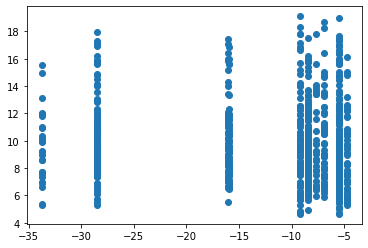

In [208]:
plt.scatter(summed_log_prob_all, summed_rt_all)
plt.show()

### GLM for the six participants: [1195,1197,1199,1203,1204] - per individual

array([[ 1.17100000e+03,  2.69543883e-02,  9.37612580e+00],
       [ 1.19500000e+03, -2.05536043e-02,  9.08995093e+00],
       [ 1.19700000e+03,  1.06273120e-03,  1.12735775e+01],
       [ 1.19900000e+03, -9.61383363e-03,  9.36682392e+00],
       [ 1.20300000e+03, -5.24807411e-02,  1.17778042e+01],
       [ 1.20400000e+03, -2.28910778e-02,  7.88739267e+00]])

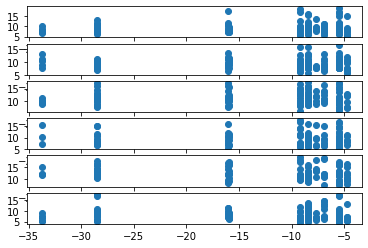

In [205]:
# Posterior/learned adjacency/co-occurence matrix

posterior = np.load(f"C:\\Users\\kmedriano\\Documents\\Cactus\\tests\\learned_adjacency\\posterior_trial.npy")

# Per participant

indiv_param = [] # param holder

fig, ax = plt.subplots(6) # creating histogram subplot for each participant

for k in session_ids:
    session_id_data = merged_selected_ids_w_actions[merged_selected_ids_w_actions.session_id == k] # slice the relevant data for session_id

    # X: summed log probabilities from the learned adjacency matrix: posterior
    solution_array = np.array(session_id_data.loc[:,'block_connect_list']) 
    array_size = solution_array.shape[0]

    summed_log_prob = np.zeros(array_size)

    for sil in np.arange(array_size):
        # list of pairs of blocks in a silhouette
        tuple_list = list(combinations(solution_array[sil],2)) #2 since we're concerned with chunks composed of 2 blocks, list of tuples
        for (i,j) in tuple_list:
            if posterior[i,j] != 0:
                summed_log_prob[sil] += np.log(posterior[i,j]) # this will most likely be a negative number

    summed_log_prob = summed_log_prob.reshape(-1,1) # this summed log predicts similar value for each silhouette

    # RT: get it from session_id_data summed_rt column 

    summed_rt = np.array(session_id_data.loc[:,'summed_rt'])
    summed_rt = summed_rt.reshape(-1,1)

    # Plot

    idx = session_ids.index(k)
    ax[idx].scatter(summed_log_prob, summed_rt)

    # RT scaling using "RT = b_0 + b_1*X where b_0 and b_1 are parameters and X is the summed log probabilities"
    # I want a value for b_0 and b_1

    reg = LinearRegression().fit(summed_log_prob,summed_rt)
    param = [k, reg.coef_[0][0], reg.intercept_[0]]

    indiv_param.append(param)

indiv_param = np.array(indiv_param)

indiv_param

In [214]:
# Coefficient check?

from scipy import stats

coeffs = indiv_param[:,1]
zeros = np.zeros(len(indiv_param[:,1]))

print(stats.ttest_ind(coeffs, zeros))

# one sample t-test

print(stats.ttest_1samp(coeffs, 0))


Ttest_indResult(statistic=-1.1929316271596933, pvalue=0.26043170050250847)
Ttest_1sampResult(statistic=-1.1929316271596933, pvalue=0.28641251033106396)


### GLM for the six participants: [1195,1197,1199,1203,1204] - per individual with additional regressor

In [243]:
from helper import *

ValueError: x and y must be the same size

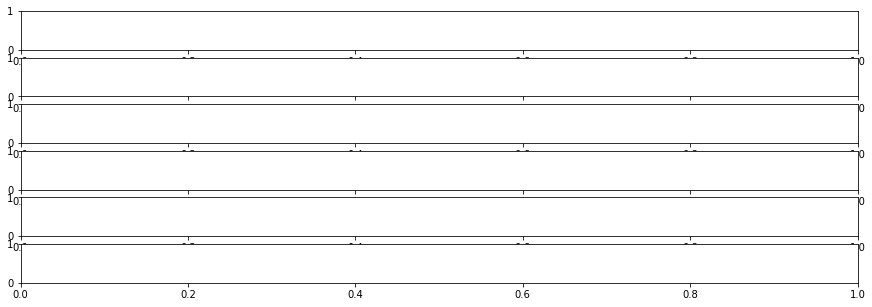

In [254]:
# Posterior/learned adjacency/co-occurence matrix

posterior = np.load(f"C:\\Users\\kmedriano\\Documents\\Cactus\\tests\\learned_adjacency\\posterior_trial.npy")

# Per participant

indiv_param = [] # param holder

#fig, ax = plt.subplots(12) # creating histogram subplot for each participant

for k in session_ids:
    session_id_data = merged_selected_ids_w_actions[merged_selected_ids_w_actions.session_id == k] # slice the relevant data for session_id

    # X: summed log probabilities from the learned adjacency matrix: posterior
    solution_array = np.array(session_id_data.loc[:,'block_connect_list']) 
    array_size = solution_array.shape[0]

    summed_log_prob_connected = np.zeros(array_size)
    summed_log_prob_co_occur = np.zeros(array_size)

    for sil in np.arange(array_size):
        # list of pairs (tuple) of blocks in a silhouette
        tuple_list_co_occur = list(combinations(solution_array[sil],2)) #2 since we're concerned with chunks composed of 2 blocks, list of tuples
        
        # only the actually connected blocks in the silhouette
        tuple_dict = tuple_counter(solution_array[sil])
        tuple_list_connected = tuple_dict.keys()

        for (i,j) in tuple_list_co_occur:
            if posterior[i,j] != 0:
                summed_log_prob_co_occur[sil] += np.log(posterior[i,j]) # this will most likely be a negative number

        for (i,j) in tuple_list_connected:
            if posterior[i,j] != 0:
                summed_log_prob_connected[sil] += np.log(posterior[i,j]) # this will most likely be a negative number

    summed_log_prob_co_occur = summed_log_prob_co_occur.reshape(-1,1) # this summed log predicts similar value for each silhouette
    summed_log_prob_connected = summed_log_prob_connected.reshape(-1,1) # this summed log predicts similar value for each silhouette
    
    summed_log_prob = np.array([summed_log_prob_co_occur, summed_log_prob_connected])
    summed_log_prob = np.squeeze(summed_log_prob.T)

    #print(summed_log_prob.shape)

    # RT: get it from session_id_data summed_rt column 

    summed_rt = np.array(session_id_data.loc[:,'summed_rt'])
    summed_rt = summed_rt.reshape(-1,1)

    #print(summed_rt.shape)

    # Plot

    # idx = session_ids.index(k)
    # ax[idx].scatter(summed_log_prob, summed_rt)

    # RT scaling using "RT = b_0 + b_1*X where b_0 and b_1 are parameters and X is the summed log probabilities"
    # I want a value for b_0 and b_1

    reg = LinearRegression().fit(summed_log_prob,summed_rt)
    param = [k, reg.coef_[0][0], reg.coef_[0][1], reg.intercept_[0]]

    indiv_param.append(param)

indiv_param = np.array(indiv_param)

indiv_param

In [223]:
a = np.arange(5)
a

array([0, 1, 2, 3, 4])

In [224]:
b = np.zeros(5)
b

array([0., 0., 0., 0., 0.])

In [228]:
c = np.array([a,b])
c

array([[0., 1., 2., 3., 4.],
       [0., 0., 0., 0., 0.]])

In [246]:
c.T
c.T.shape

(5, 2)

In [234]:
d = np.array([np.transpose(a),np.transpose(b)])
d

array([[0., 1., 2., 3., 4.],
       [0., 0., 0., 0., 0.]])

In [235]:
d.shape

(2, 5)

In [238]:
e = np.transpose(a)

In [239]:
e.shape

(5,)

In [240]:
a.shape

(5,)